In [2]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.preprocessing import OneHotEncoder

In [3]:
class Layer:

    def __init__(self, num_neurons, num_arg, activate_fun):
        # normal distribution
        # self.weight_array = np.random.uniform(0, 10**(-10), (num_neurons, num_arg))
        # self.bias_array = np.random.uniform(0, 10**(-10), (num_neurons, 1))
        
        # He (Kaiming Initialization)
        self.weight_array = np.random.normal(0, math.sqrt(2/num_arg), (num_neurons, num_arg))
        self.bias_array = np.random.normal(0, math.sqrt(2/num_arg), (num_neurons, 1))
        self.activate_fun = activate_fun
        self.last_activation = None
        self.last_argument = None
        
        self.weight_momentum = np.zeros((num_neurons, num_arg))
        self.bias_momentum = np.zeros((num_neurons, 1))

        self.weight_rmsprop = np.zeros((num_neurons, num_arg))
        self.bias_rmsprop = np.zeros((num_neurons, 1))


    def forward(self, arguments_array):
        f = self.weight_array @ arguments_array + self.bias_array
        g = self.activate_fun.activate(f)
        self.last_activation = g.copy()
        self.last_argument = arguments_array.copy()
        return g

class Network:

    def __init__(self, size_layers, size_input, activate_fun_array):
        self.size_layers = size_layers
        self.size_input = size_input

        num_arg = [size_input] + size_layers
        self.layers = [Layer(size_layers[i], num_arg[i], activate_fun_array[i]) for i in range(len(size_layers))]
        self.mse_list = []
        self.f_score_list = []
        
        self.Y_mean = None
        self.Y_std = None
        self.X_mean = None
        self.X_std = None
        
        self.Y_best_predict = None
        self.f_score_best = 0


    def forward(self, arguments_array, denormalize=False):

        
        for layer in self.layers:
            arguments_array = layer.forward(arguments_array)

        if denormalize:
            arguments_array = arguments_array * self.Y_std + self.Y_mean
            
        return arguments_array


    def backprop(self, x, y, params):
        y_hat = self.forward(x)
        dL_dg = self.layers[-1].activate_fun.derivative_last(y, y_hat)
        dL_df = dL_dg
        dL_dw = dL_df @ self.layers[-1].last_argument.T
        dL_db = dL_df
        self.layers[-1].weight_array -= (params["eta"] * dL_dw / x.shape[1]).copy()
        self.layers[-1].bias_array -= ((params["eta"] * np.sum(dL_db, axis=1) / x.shape[1]).reshape(-1, 1)).copy()
        dL_dg = self.layers[-1].weight_array.T @ dL_df
        for layer in reversed(self.layers[:-1]):
            dL_df = dL_dg * layer.activate_fun.derivative(layer.last_activation)
            dL_dw = dL_df @ layer.last_argument.T
            dL_db = dL_df
            layer.weight_array -= (params["eta"] * dL_dw / x.shape[1]).copy()
            layer.bias_array -= ((params["eta"] * np.sum(dL_db, axis=1) / x.shape[1]).reshape(-1, 1)).copy()
            dL_dg = layer.weight_array.T @ dL_df

                       
    def mini_batches(self, X, Y, batch_size):
        num_samples = X.shape[1]
        
        new_index = np.arange(num_samples)
        np.random.shuffle(new_index)
        X_shuffled = X[:, new_index]
        Y_shuffled = Y[:, new_index]
        
        for start_ind in range(0, num_samples, batch_size):
            end_ind = min(start_ind + batch_size, num_samples)
            yield X_shuffled[:, start_ind:end_ind], Y_shuffled[:, start_ind:end_ind]
    
    
    def normalize(self, Y):    
        return (Y - self.Y_mean) / self.Y_std


    def z_score_normalize(self, X, X_mean, X_std):
        X_norm = (X - X_mean) / X_std
        return X_norm
    
    
    def train(self, X, Y, X_test, Y_test, epochs, params, batch_size, type, norm):
        
        Y_norm = Y
        
        if norm:
            self.X_mean = X.mean(axis=1).reshape(-1, 1)
            self.X_std = X.std(axis=1).reshape(-1, 1)
            
            X = self.z_score_normalize(X, self.X_mean, self.X_std)
            X_test = self.z_score_normalize(X_test, self.X_mean, self.X_std)
            
            if type  == 'regression':
                self.Y_mean = np.mean(Y, axis=1).reshape(-1, 1)
                self.Y_std = np.std(Y, axis=1).reshape(-1, 1)
                
                Y_norm = self.normalize(Y)
        
        for epoch in range(epochs):
            for x_batch, y_batch in self.mini_batches(X, Y_norm, batch_size):
                self.backprop(x_batch, y_batch, params)
            
            if type == 'regression':
                y_hat_ = self.forward(X_test, True and norm)
                mse_test = np.mean((y_hat_ - Y_test) ** 2)
                y_hat_ = self.forward(X, True and norm)
                mse = np.mean((y_hat_ - Y) ** 2)
                self.mse_list.append(mse)
                if epoch % 100 == 0:
                    print(f"Epoch {epoch+1}/{epochs}, MSE = {mse:.4f}, MSE test = {mse_test:.4f}")
                    
            elif type == 'classification':
                y_hat_ = self.forward(X)
                f_score = f1_score(np.argmax(Y, axis=0), np.argmax(y_hat_, axis=0), average='macro')
                if f_score > self.f_score_best:
                    self.f_score_best = f_score
                    self.Y_best_predict = self.forward(X_test)
                y_hat_ = self.forward(X_test)
                f_score_test = f1_score(np.argmax(Y_test, axis=0), np.argmax(y_hat_, axis=0), average='macro')
                self.f_score_list.append(f_score)
                if epoch % 100 == 0:
                    print(f"Epoch {epoch+1}/{epochs}, f-score = {f_score}, f-score test= {f_score_test}")


class Sigmoid:
    
    def activate(self, v):
        v = v.astype(np.longdouble)
        return 1.0 / (1.0 + np.exp(-v))
    def derivative(self, v):
        return v * (1 - v)


class Linear:
    
    def activate(self, v):
        v = v.astype(np.longdouble)
        return v
    def derivative(self, v):
        return 1
    def derivative_last(self, v, v_hat):
        return v_hat - v


class Softmax:
    
    def activate(self, v):
        v_max = np.max(v, axis=0, keepdims=True)
        v_shifted = v - v_max
        exp_v = np.exp(v_shifted)
        softmax_scores = exp_v / np.sum(exp_v, axis=0, keepdims=True)
        return softmax_scores
    def derivative_last(self, v, v_hat):
        return v_hat - v


class Tanh:

    def activate(self, v):
        v = v.astype(np.longdouble)
        # return (np.exp(v) - np.exp(-v)) / (np.exp(v) + np.exp(-v))
        return (2 / (1 + np.exp(-2 * v))) - 1
    def derivative(self, v):
        return 1 - (self.activate(v))**2


class ReLU:

    def activate(self, v):
        v = v.astype(np.longdouble)
        return np.maximum(0, v)
    def derivative(self, v):
        v = v.astype(np.longdouble)
        return (v > 0) * 1


class Momentum_Network(Network):

    def backprop(self, x, y, params):
        y_hat = self.forward(x)
        dL_dg = self.layers[-1].activate_fun.derivative_last(y, y_hat)
        dL_df = dL_dg
        dL_dw = dL_df @ self.layers[-1].last_argument.T
        dL_db = dL_df

        self.layers[-1].weight_momentum = params["momentum"] * self.layers[-1].weight_momentum + params["eta"] * dL_dw / x.shape[1]
        self.layers[-1].bias_momentum = params["momentum"] * self.layers[-1].bias_momentum + (params["eta"] * np.sum(dL_db, axis=1) / x.shape[1]).reshape(-1, 1)
        self.layers[-1].weight_array -= self.layers[-1].weight_momentum
        self.layers[-1].bias_array -= self.layers[-1].bias_momentum

        dL_dg = self.layers[-1].weight_array.T @ dL_df

        for layer in reversed(self.layers[:-1]):
            dL_df = dL_dg * layer.activate_fun.derivative(layer.last_activation)
            dL_dw = dL_df @ layer.last_argument.T
            dL_db = dL_df
            layer.weight_momentum = params["momentum"] * layer.weight_momentum + params["eta"] * dL_dw / x.shape[1]
            layer.bias_momentum = params["momentum"] * layer.bias_momentum + (params["eta"] * np.sum(dL_db, axis=1) / x.shape[1]).reshape(-1, 1)
            layer.weight_array -= layer.weight_momentum
            layer.bias_array -= layer.bias_momentum
            dL_dg = layer.weight_array.T @ dL_df


# Testy dla multimodal-large

In [4]:
ml_train = pd.read_csv('NN\\regression\\multimodal-large-training.csv', dtype=np.longdouble)
ml_test = pd.read_csv('NN\\regression\\multimodal-large-test.csv', dtype=np.longdouble)
X_ml = ml_train['x'].values.reshape(1, -1)
y_ml = ml_train['y'].values.reshape(1, -1)
X_test_ml = ml_test['x'].values.reshape(1, -1)
y_test_ml = ml_test['y'].values.reshape(1, -1)

In [172]:
best_networks = {
    "sigmoid_1": None,
    "sigmoid_2": None,
    "sigmoid_3": None,
    "tanh_1": None,
    "tanh_2": None,
    "tanh_3": None,
    "relu_1": None,
    "relu_2": None,
    "relu_3": None,
    "linear_1": None,
    "linear_2": None,
    "linear_3": None
}

## Sigmoid()

In [173]:
name = "sigmoid_1"
layers = [30, 1]
fun_activation = [Sigmoid() for _ in range(len(layers) - 1)] + [Linear()]
params = {"eta": 0.05, "momentum": 0.8}

N = Momentum_Network(size_layers=layers, size_input=1, activate_fun_array=fun_activation)
N.train(X=X_ml, Y=y_ml, X_test=X_test_ml, Y_test=y_test_ml, epochs=4000, params=params, batch_size=64, type='regression', norm=True)
if best_networks[name] is None:
    best_networks[name] = N
else:
    if min(best_networks[name].mse_list) > min(N.mse_list):
        best_networks[name] = N

Epoch 1/4000, MSE = 2738.0695, MSE test = 2749.6424
Epoch 101/4000, MSE = 324.2303, MSE test = 327.2461
Epoch 201/4000, MSE = 317.5310, MSE test = 318.2313
Epoch 301/4000, MSE = 290.5514, MSE test = 297.0983
Epoch 401/4000, MSE = 251.2174, MSE test = 258.2750
Epoch 501/4000, MSE = 193.1020, MSE test = 195.4326
Epoch 601/4000, MSE = 155.9914, MSE test = 154.4839
Epoch 701/4000, MSE = 121.8585, MSE test = 119.5040
Epoch 801/4000, MSE = 106.2231, MSE test = 103.4838
Epoch 901/4000, MSE = 95.8816, MSE test = 93.1095
Epoch 1001/4000, MSE = 92.5203, MSE test = 87.6556
Epoch 1101/4000, MSE = 85.9833, MSE test = 81.7464
Epoch 1201/4000, MSE = 83.6076, MSE test = 79.9531
Epoch 1301/4000, MSE = 84.5603, MSE test = 81.6918
Epoch 1401/4000, MSE = 84.3461, MSE test = 81.5643
Epoch 1501/4000, MSE = 76.8747, MSE test = 73.2763
Epoch 1601/4000, MSE = 76.7092, MSE test = 72.2865
Epoch 1701/4000, MSE = 80.4913, MSE test = 77.4409
Epoch 1801/4000, MSE = 76.1581, MSE test = 71.7171
Epoch 1901/4000, MSE = 

In [175]:
name = "sigmoid_2"
layers = [10, 15, 1]
fun_activation = [Sigmoid() for _ in range(len(layers) - 1)] + [Linear()]
params = {"eta": 0.05, "momentum": 0.8}

N = Momentum_Network(size_layers=layers, size_input=1, activate_fun_array=fun_activation)
N.train(X=X_ml, Y=y_ml, X_test=X_test_ml, Y_test=y_test_ml, epochs=4000, params=params, batch_size=64, type='regression', norm=True)
if best_networks[name] is None:
    best_networks[name] = N
else:
    if min(best_networks[name].mse_list) > min(N.mse_list):
        best_networks[name] = N

Epoch 1/4000, MSE = 3410.5390, MSE test = 3405.7826
Epoch 101/4000, MSE = 393.3104, MSE test = 400.2536
Epoch 201/4000, MSE = 345.3237, MSE test = 356.1805
Epoch 301/4000, MSE = 296.6774, MSE test = 304.1750
Epoch 401/4000, MSE = 287.7503, MSE test = 287.8403
Epoch 501/4000, MSE = 196.0960, MSE test = 199.3150
Epoch 601/4000, MSE = 100.0924, MSE test = 101.3282
Epoch 701/4000, MSE = 42.2462, MSE test = 40.1399
Epoch 801/4000, MSE = 31.2537, MSE test = 28.8806
Epoch 901/4000, MSE = 24.0380, MSE test = 21.0246
Epoch 1001/4000, MSE = 18.3817, MSE test = 14.7840
Epoch 1101/4000, MSE = 13.8955, MSE test = 10.4388
Epoch 1201/4000, MSE = 10.8594, MSE test = 7.0521
Epoch 1301/4000, MSE = 9.0860, MSE test = 5.1721
Epoch 1401/4000, MSE = 8.4513, MSE test = 4.3371
Epoch 1501/4000, MSE = 8.2398, MSE test = 4.6116
Epoch 1601/4000, MSE = 7.9402, MSE test = 3.8156
Epoch 1701/4000, MSE = 7.9135, MSE test = 4.0049
Epoch 1801/4000, MSE = 7.7780, MSE test = 3.8528
Epoch 1901/4000, MSE = 7.8440, MSE test 

In [177]:
name = "sigmoid_3"
layers = [10, 15, 10, 1]
fun_activation = [Sigmoid() for _ in range(len(layers) - 1)] + [Linear()]
params = {"eta": 0.05, "momentum": 0.8}

N = Momentum_Network(size_layers=layers, size_input=1, activate_fun_array=fun_activation)
N.train(X=X_ml, Y=y_ml, X_test=X_test_ml, Y_test=y_test_ml, epochs=4000, params=params, batch_size=64, type='regression', norm=True)
if best_networks[name] is None:
    best_networks[name] = N
else:
    if min(best_networks[name].mse_list) > min(N.mse_list):
        best_networks[name] = N

Epoch 1/4000, MSE = 3960.8008, MSE test = 3981.4057
Epoch 101/4000, MSE = 350.6130, MSE test = 358.7422
Epoch 201/4000, MSE = 303.5013, MSE test = 310.2813
Epoch 301/4000, MSE = 117.8221, MSE test = 122.9894
Epoch 401/4000, MSE = 19.3845, MSE test = 15.7574
Epoch 501/4000, MSE = 8.4349, MSE test = 4.2654
Epoch 601/4000, MSE = 7.5929, MSE test = 3.6173
Epoch 701/4000, MSE = 8.2151, MSE test = 3.7111
Epoch 801/4000, MSE = 7.4099, MSE test = 3.5434
Epoch 901/4000, MSE = 7.2611, MSE test = 2.9263
Epoch 1001/4000, MSE = 7.0333, MSE test = 2.8370
Epoch 1101/4000, MSE = 7.0264, MSE test = 2.8366
Epoch 1201/4000, MSE = 7.2775, MSE test = 2.9667
Epoch 1301/4000, MSE = 7.0332, MSE test = 2.7550
Epoch 1401/4000, MSE = 6.9963, MSE test = 2.8992
Epoch 1501/4000, MSE = 6.9710, MSE test = 3.0108
Epoch 1601/4000, MSE = 6.9107, MSE test = 2.4947
Epoch 1701/4000, MSE = 7.0008, MSE test = 2.7930
Epoch 1801/4000, MSE = 6.8526, MSE test = 2.6819
Epoch 1901/4000, MSE = 7.2377, MSE test = 3.2278
Epoch 2001/4

## Tanh()

In [185]:
name = "tanh_1"
layers = [30, 1]
fun_activation = [Tanh() for _ in range(len(layers) - 1)] + [Linear()]
params = {"eta": 0.01, "momentum": 0.9}

N = Momentum_Network(size_layers=layers, size_input=1, activate_fun_array=fun_activation)
N.train(X=X_ml, Y=y_ml, X_test=X_test_ml, Y_test=y_test_ml, epochs=4000, params=params, batch_size=64, type='regression', norm=True)
if best_networks[name] is None:
    best_networks[name] = N
else:
    if min(best_networks[name].mse_list) > min(N.mse_list):
        best_networks[name] = N

Epoch 1/4000, MSE = 1728.0455, MSE test = 1769.0271
Epoch 101/4000, MSE = 289.5358, MSE test = 294.0597
Epoch 201/4000, MSE = 233.7084, MSE test = 239.8489
Epoch 301/4000, MSE = 192.3707, MSE test = 195.3958
Epoch 401/4000, MSE = 159.3822, MSE test = 159.3494
Epoch 501/4000, MSE = 115.7789, MSE test = 113.0398
Epoch 601/4000, MSE = 94.9500, MSE test = 90.0812
Epoch 701/4000, MSE = 86.2184, MSE test = 80.8280
Epoch 801/4000, MSE = 82.3263, MSE test = 76.1260
Epoch 901/4000, MSE = 75.4039, MSE test = 69.5662
Epoch 1001/4000, MSE = 71.9386, MSE test = 66.1141
Epoch 1101/4000, MSE = 65.6441, MSE test = 59.2376
Epoch 1201/4000, MSE = 83.7944, MSE test = 79.4538
Epoch 1301/4000, MSE = 53.7772, MSE test = 47.6054
Epoch 1401/4000, MSE = 46.6560, MSE test = 41.0422
Epoch 1501/4000, MSE = 40.7603, MSE test = 35.2252
Epoch 1601/4000, MSE = 34.7878, MSE test = 29.4181
Epoch 1701/4000, MSE = 29.2697, MSE test = 23.6939
Epoch 1801/4000, MSE = 23.7485, MSE test = 18.4974
Epoch 1901/4000, MSE = 25.245

In [188]:
name = "tanh_2"
layers = [10, 10, 1]
fun_activation = [Tanh() for _ in range(len(layers) - 1)] + [Linear()]
params = {"eta": 0.005, "momentum": 0.8}

N = Momentum_Network(size_layers=layers, size_input=1, activate_fun_array=fun_activation)
N.train(X=X_ml, Y=y_ml, X_test=X_test_ml, Y_test=y_test_ml, epochs=4000, params=params, batch_size=64, type='regression', norm=True)
if best_networks[name] is None:
    best_networks[name] = N
else:
    if min(best_networks[name].mse_list) > min(N.mse_list):
        best_networks[name] = N

Epoch 1/4000, MSE = 1917.8508, MSE test = 1942.9858
Epoch 101/4000, MSE = 292.8992, MSE test = 296.8291
Epoch 201/4000, MSE = 203.9934, MSE test = 201.7527
Epoch 301/4000, MSE = 152.7970, MSE test = 146.5934
Epoch 401/4000, MSE = 96.9685, MSE test = 91.7752
Epoch 501/4000, MSE = 73.1172, MSE test = 67.6849
Epoch 601/4000, MSE = 64.7239, MSE test = 58.6277
Epoch 701/4000, MSE = 62.4490, MSE test = 56.0818
Epoch 801/4000, MSE = 60.2930, MSE test = 54.1191
Epoch 901/4000, MSE = 59.0519, MSE test = 53.0149
Epoch 1001/4000, MSE = 58.1357, MSE test = 52.6503
Epoch 1101/4000, MSE = 57.8285, MSE test = 52.0248
Epoch 1201/4000, MSE = 57.4774, MSE test = 52.1658
Epoch 1301/4000, MSE = 58.8718, MSE test = 52.7505
Epoch 1401/4000, MSE = 57.2159, MSE test = 51.8310
Epoch 1501/4000, MSE = 56.7694, MSE test = 51.3874
Epoch 1601/4000, MSE = 56.5961, MSE test = 51.0310
Epoch 1701/4000, MSE = 56.3274, MSE test = 50.5919
Epoch 1801/4000, MSE = 55.2517, MSE test = 49.6347
Epoch 1901/4000, MSE = 54.2693, M

In [187]:
name = "tanh_3"
layers = [10, 15, 10, 1]
fun_activation = [Tanh() for _ in range(len(layers) - 1)] + [Linear()]
params = {"eta": 0.01, "momentum": 0.9}

N = Momentum_Network(size_layers=layers, size_input=1, activate_fun_array=fun_activation)
N.train(X=X_ml, Y=y_ml, X_test=X_test_ml, Y_test=y_test_ml, epochs=4000, params=params, batch_size=64, type='regression', norm=True)
if best_networks[name] is None:
    best_networks[name] = N
else:
    if min(best_networks[name].mse_list) > min(N.mse_list):
        best_networks[name] = N

Epoch 1/4000, MSE = 2506.3302, MSE test = 2560.6691
Epoch 101/4000, MSE = 61.9403, MSE test = 58.1943
Epoch 201/4000, MSE = 14.9512, MSE test = 11.5878
Epoch 301/4000, MSE = 8.5811, MSE test = 4.4503
Epoch 401/4000, MSE = 6.7815, MSE test = 2.5231
Epoch 501/4000, MSE = 6.6635, MSE test = 2.1720
Epoch 601/4000, MSE = 6.2996, MSE test = 1.8917
Epoch 701/4000, MSE = 6.3574, MSE test = 1.8874
Epoch 801/4000, MSE = 6.4720, MSE test = 2.3705
Epoch 901/4000, MSE = 6.3654, MSE test = 2.1467
Epoch 1001/4000, MSE = 6.0089, MSE test = 1.9114
Epoch 1101/4000, MSE = 6.3404, MSE test = 2.6022
Epoch 1201/4000, MSE = 5.7947, MSE test = 1.8976
Epoch 1301/4000, MSE = 7.2242, MSE test = 4.0194
Epoch 1401/4000, MSE = 5.6752, MSE test = 2.0213
Epoch 1501/4000, MSE = 5.7143, MSE test = 1.9060
Epoch 1601/4000, MSE = 5.9610, MSE test = 2.0589
Epoch 1701/4000, MSE = 5.6186, MSE test = 1.9386
Epoch 1801/4000, MSE = 5.8759, MSE test = 2.4919
Epoch 1901/4000, MSE = 5.4189, MSE test = 1.8340
Epoch 2001/4000, MSE =

## ReLU()

In [178]:
name = "relu_1"
layers = [30, 1]
fun_activation = [ReLU() for _ in range(len(layers) - 1)] + [Linear()]
params = {"eta": 0.001, "momentum": 0.5}

N = Momentum_Network(size_layers=layers, size_input=1, activate_fun_array=fun_activation)
N.train(X=X_ml, Y=y_ml, X_test=X_test_ml, Y_test=y_test_ml, epochs=4000, params=params, batch_size=64, type='regression', norm=True)
if best_networks[name] is None:
    best_networks[name] = N
else:
    if min(best_networks[name].mse_list) > min(N.mse_list):
        best_networks[name] = N

Epoch 1/4000, MSE = 5328.7616, MSE test = 5378.8387
Epoch 101/4000, MSE = 1482.5256, MSE test = 1485.6365
Epoch 201/4000, MSE = 996.0886, MSE test = 1020.2729
Epoch 301/4000, MSE = 726.4360, MSE test = 752.5730
Epoch 401/4000, MSE = 574.6674, MSE test = 598.8631
Epoch 501/4000, MSE = 481.9494, MSE test = 501.9463
Epoch 601/4000, MSE = 417.6338, MSE test = 433.7884
Epoch 701/4000, MSE = 371.6171, MSE test = 383.7578
Epoch 801/4000, MSE = 339.5016, MSE test = 349.8255
Epoch 901/4000, MSE = 315.0383, MSE test = 322.4985
Epoch 1001/4000, MSE = 293.8838, MSE test = 299.7011
Epoch 1101/4000, MSE = 279.3497, MSE test = 282.2425
Epoch 1201/4000, MSE = 266.2780, MSE test = 268.8461
Epoch 1301/4000, MSE = 254.6839, MSE test = 256.3341
Epoch 1401/4000, MSE = 243.5172, MSE test = 245.3933
Epoch 1501/4000, MSE = 232.9809, MSE test = 235.1986
Epoch 1601/4000, MSE = 221.9046, MSE test = 221.9015
Epoch 1701/4000, MSE = 213.2177, MSE test = 212.2061
Epoch 1801/4000, MSE = 206.0852, MSE test = 205.3024


In [182]:
name = "relu_2"
layers = [10, 10, 1]
fun_activation = [ReLU() for _ in range(len(layers) - 1)] + [Linear()]
params = {"eta": 0.001, "momentum": 0.6}

N = Momentum_Network(size_layers=layers, size_input=1, activate_fun_array=fun_activation)
N.train(X=X_ml, Y=y_ml, X_test=X_test_ml, Y_test=y_test_ml, epochs=4000, params=params, batch_size=64, type='regression', norm=True)
if best_networks[name] is None:
    best_networks[name] = N
else:
    if min(best_networks[name].mse_list) > min(N.mse_list):
        best_networks[name] = N

Epoch 1/4000, MSE = 3294.1325, MSE test = 3287.7075
Epoch 101/4000, MSE = 1605.6492, MSE test = 1622.2042
Epoch 201/4000, MSE = 1334.3505, MSE test = 1359.2087
Epoch 301/4000, MSE = 467.1942, MSE test = 478.3837
Epoch 401/4000, MSE = 295.6977, MSE test = 292.7301
Epoch 501/4000, MSE = 270.1946, MSE test = 264.1809
Epoch 601/4000, MSE = 260.3704, MSE test = 253.4085
Epoch 701/4000, MSE = 253.1824, MSE test = 247.9635
Epoch 801/4000, MSE = 247.7444, MSE test = 243.6098
Epoch 901/4000, MSE = 243.9273, MSE test = 239.1355
Epoch 1001/4000, MSE = 242.9368, MSE test = 237.0162
Epoch 1101/4000, MSE = 237.9005, MSE test = 230.8515
Epoch 1201/4000, MSE = 241.9096, MSE test = 240.0640
Epoch 1301/4000, MSE = 238.3488, MSE test = 228.0093
Epoch 1401/4000, MSE = 243.3266, MSE test = 231.0470
Epoch 1501/4000, MSE = 226.8132, MSE test = 218.3242
Epoch 1601/4000, MSE = 224.1434, MSE test = 216.1569
Epoch 1701/4000, MSE = 224.2567, MSE test = 214.0484
Epoch 1801/4000, MSE = 228.2424, MSE test = 224.3481

In [184]:
name = "relu_3"
layers = [10, 15, 10, 1]
fun_activation = [ReLU() for _ in range(len(layers) - 1)] + [Linear()]
params = {"eta": 0.001, "momentum": 0.7}

N = Momentum_Network(size_layers=layers, size_input=1, activate_fun_array=fun_activation)
N.train(X=X_ml, Y=y_ml, X_test=X_test_ml, Y_test=y_test_ml, epochs=4000, params=params, batch_size=64, type='regression', norm=True)
if best_networks[name] is None:
    best_networks[name] = N
else:
    if min(best_networks[name].mse_list) > min(N.mse_list):
        best_networks[name] = N

Epoch 1/4000, MSE = 3644.4433, MSE test = 3661.2320
Epoch 101/4000, MSE = 300.1954, MSE test = 321.4989
Epoch 201/4000, MSE = 201.4570, MSE test = 208.4733
Epoch 301/4000, MSE = 150.5693, MSE test = 155.5233
Epoch 401/4000, MSE = 115.6947, MSE test = 122.5079
Epoch 501/4000, MSE = 82.8837, MSE test = 88.9659
Epoch 601/4000, MSE = 59.2312, MSE test = 61.3601
Epoch 701/4000, MSE = 42.0326, MSE test = 42.5443
Epoch 801/4000, MSE = 32.5738, MSE test = 31.0882
Epoch 901/4000, MSE = 24.2160, MSE test = 22.1602
Epoch 1001/4000, MSE = 20.4475, MSE test = 17.8873
Epoch 1101/4000, MSE = 18.4419, MSE test = 14.9701
Epoch 1201/4000, MSE = 15.3340, MSE test = 11.7524
Epoch 1301/4000, MSE = 15.0782, MSE test = 11.6927
Epoch 1401/4000, MSE = 13.2036, MSE test = 9.2149
Epoch 1501/4000, MSE = 12.8192, MSE test = 8.6822
Epoch 1601/4000, MSE = 11.4175, MSE test = 7.1126
Epoch 1701/4000, MSE = 11.3244, MSE test = 7.4665
Epoch 1801/4000, MSE = 10.6321, MSE test = 6.1662
Epoch 1901/4000, MSE = 10.5820, MSE 

## Linear

In [190]:
name = ("linear_1")
layers = [30, 1]
fun_activation = [Linear() for _ in range(len(layers) - 1)] + [Linear()]
params = {"eta": 0.001, "momentum": 0.5}

N = Momentum_Network(size_layers=layers, size_input=1, activate_fun_array=fun_activation)
N.train(X=X_ml, Y=y_ml, X_test=X_test_ml, Y_test=y_test_ml, epochs=4000, params=params, batch_size=64, type='regression', norm=True)
if best_networks[name] is None:
    best_networks[name] = N
else:
    if min(best_networks[name].mse_list) > min(N.mse_list):
        best_networks[name] = N

Epoch 1/4000, MSE = 4399.2291, MSE test = 4434.8298
Epoch 101/4000, MSE = 4405.7890, MSE test = 4441.4104
Epoch 201/4000, MSE = 4401.5298, MSE test = 4438.3491
Epoch 301/4000, MSE = 4400.1490, MSE test = 4435.4068
Epoch 401/4000, MSE = 4401.6881, MSE test = 4436.0007
Epoch 501/4000, MSE = 4407.9456, MSE test = 4442.9572
Epoch 601/4000, MSE = 4403.5733, MSE test = 4437.4683
Epoch 701/4000, MSE = 4399.6200, MSE test = 4435.9033
Epoch 801/4000, MSE = 4401.2154, MSE test = 4437.9457
Epoch 901/4000, MSE = 4403.1129, MSE test = 4440.1331
Epoch 1001/4000, MSE = 4402.3503, MSE test = 4438.6865
Epoch 1101/4000, MSE = 4403.0798, MSE test = 4440.1834
Epoch 1201/4000, MSE = 4401.6482, MSE test = 4437.4362
Epoch 1301/4000, MSE = 4401.4572, MSE test = 4435.6722
Epoch 1401/4000, MSE = 4401.8812, MSE test = 4436.0353
Epoch 1501/4000, MSE = 4399.4675, MSE test = 4434.5997
Epoch 1601/4000, MSE = 4401.5994, MSE test = 4437.9621
Epoch 1701/4000, MSE = 4398.6746, MSE test = 4434.1662
Epoch 1801/4000, MSE =

In [191]:
name = ("linear_2")
layers = [10, 10, 1]
fun_activation = [Linear() for _ in range(len(layers) - 1)] + [Linear()]
params = {"eta": 0.003, "momentum": 0.6}

N = Momentum_Network(size_layers=layers, size_input=1, activate_fun_array=fun_activation)
N.train(X=X_ml, Y=y_ml, X_test=X_test_ml, Y_test=y_test_ml, epochs=4000, params=params, batch_size=64, type='regression', norm=True)
if best_networks[name] is None:
    best_networks[name] = N
else:
    if min(best_networks[name].mse_list) > min(N.mse_list):
        best_networks[name] = N

Epoch 1/4000, MSE = 4401.8678, MSE test = 4436.1655
Epoch 101/4000, MSE = 4484.7953, MSE test = 4516.6091
Epoch 201/4000, MSE = 4416.9701, MSE test = 4455.6328
Epoch 301/4000, MSE = 4411.3945, MSE test = 4446.2910
Epoch 401/4000, MSE = 4430.9046, MSE test = 4468.0860
Epoch 501/4000, MSE = 4402.3692, MSE test = 4438.7726
Epoch 601/4000, MSE = 4416.2608, MSE test = 4452.6990
Epoch 701/4000, MSE = 4403.5429, MSE test = 4440.6417
Epoch 801/4000, MSE = 4400.5404, MSE test = 4435.0502
Epoch 901/4000, MSE = 4401.8976, MSE test = 4436.3815
Epoch 1001/4000, MSE = 4411.4278, MSE test = 4446.5740
Epoch 1101/4000, MSE = 4403.3678, MSE test = 4439.7927
Epoch 1201/4000, MSE = 4403.9941, MSE test = 4441.2416
Epoch 1301/4000, MSE = 4418.8891, MSE test = 4455.2177
Epoch 1401/4000, MSE = 4430.3362, MSE test = 4464.3647
Epoch 1501/4000, MSE = 4398.8013, MSE test = 4434.1739
Epoch 1601/4000, MSE = 4415.7125, MSE test = 4448.9783
Epoch 1701/4000, MSE = 4409.6558, MSE test = 4445.2388
Epoch 1801/4000, MSE =

In [192]:
name = ("linear_3")
layers = [10, 15, 10, 1]
fun_activation = [Linear() for _ in range(len(layers) - 1)] + [Linear()]
params = {"eta": 0.003, "momentum": 0.6}

N = Momentum_Network(size_layers=layers, size_input=1, activate_fun_array=fun_activation)
N.train(X=X_ml, Y=y_ml, X_test=X_test_ml, Y_test=y_test_ml, epochs=4000, params=params, batch_size=64, type='regression', norm=True)
if best_networks[name] is None:
    best_networks[name] = N
else:
    if min(best_networks[name].mse_list) > min(N.mse_list):
        best_networks[name] = N

Epoch 1/4000, MSE = 4588.3926, MSE test = 4633.0325
Epoch 101/4000, MSE = 4648.7444, MSE test = 4672.4780
Epoch 201/4000, MSE = 4431.7938, MSE test = 4470.8292
Epoch 301/4000, MSE = 4416.8792, MSE test = 4453.8658
Epoch 401/4000, MSE = 4400.5424, MSE test = 4436.5345
Epoch 501/4000, MSE = 4425.3617, MSE test = 4464.6256
Epoch 601/4000, MSE = 4399.3827, MSE test = 4434.8636
Epoch 701/4000, MSE = 4415.4480, MSE test = 4447.9177
Epoch 801/4000, MSE = 4406.5067, MSE test = 4440.7070
Epoch 901/4000, MSE = 4407.8707, MSE test = 4442.2975
Epoch 1001/4000, MSE = 4409.0545, MSE test = 4442.1221
Epoch 1101/4000, MSE = 4402.4969, MSE test = 4439.4675
Epoch 1201/4000, MSE = 4407.0999, MSE test = 4440.3866
Epoch 1301/4000, MSE = 4398.2736, MSE test = 4433.8081
Epoch 1401/4000, MSE = 4403.5609, MSE test = 4437.5895
Epoch 1501/4000, MSE = 4400.0370, MSE test = 4436.4714
Epoch 1601/4000, MSE = 4422.6682, MSE test = 4456.3085
Epoch 1701/4000, MSE = 4400.6568, MSE test = 4436.0752
Epoch 1801/4000, MSE =

## Results

In [195]:
for key, val in best_networks.items():
    print(f"{key}: min_MSE = {min(val.mse_list)}")

sigmoid_1: min_MSE = 32.78704389562304
sigmoid_2: min_MSE = 7.227682591128357
sigmoid_3: min_MSE = 6.347881828587966
tanh_1: min_MSE = 9.29577146129873
tanh_2: min_MSE = 9.502219062619757
tanh_3: min_MSE = 4.290661737716878
relu_1: min_MSE = 137.5037185657523
relu_2: min_MSE = 212.84809031880707
relu_3: min_MSE = 8.388536648670671
linear_1: min_MSE = 4398.222328757129
linear_2: min_MSE = 4398.22467211209
linear_3: min_MSE = 4398.222244997294


### Best
- tanh() z 3 warstwami ukrytymi
- sigmoid() z 3 warstwami ukrytymi

# Regresja

## Steps-large

In [13]:
sl_train = pd.read_csv('NN\\regression\\steps-large-training.csv', dtype=np.longdouble)
sl_test = pd.read_csv('NN\\regression\\steps-large-test.csv', dtype=np.longdouble)
X_sl = sl_train['x'].values.reshape(1, -1)
y_sl = sl_train['y'].values.reshape(1, -1)
X_test_sl = sl_test['x'].values.reshape(1, -1)
y_test_sl = sl_test['y'].values.reshape(1, -1)

In [6]:
layers = [10, 15, 10, 1]
fun_activation = [Tanh() for _ in range(len(layers) - 1)] + [Linear()]
params = {"eta": 0.01, "momentum": 0.9}

N_sl_tanh = Momentum_Network(size_layers=layers, size_input=1, activate_fun_array=fun_activation)
N_sl_tanh.train(X=X_sl, Y=y_sl, X_test=X_test_sl, Y_test=y_test_sl, epochs=4000, params=params, batch_size=64, type='regression', norm=True)

Epoch 1/4000, MSE = 441.9114, MSE test = 447.9175
Epoch 101/4000, MSE = 71.0786, MSE test = 68.8239
Epoch 201/4000, MSE = 43.5155, MSE test = 45.5856
Epoch 301/4000, MSE = 32.1342, MSE test = 31.0242
Epoch 401/4000, MSE = 26.9780, MSE test = 24.4624
Epoch 501/4000, MSE = 22.9476, MSE test = 20.0593
Epoch 601/4000, MSE = 21.3658, MSE test = 15.7732
Epoch 701/4000, MSE = 19.1794, MSE test = 14.1003
Epoch 801/4000, MSE = 17.9735, MSE test = 12.7365
Epoch 901/4000, MSE = 18.0038, MSE test = 17.9540
Epoch 1001/4000, MSE = 17.3563, MSE test = 13.8719
Epoch 1101/4000, MSE = 15.8014, MSE test = 11.5506
Epoch 1201/4000, MSE = 15.5301, MSE test = 14.4518
Epoch 1301/4000, MSE = 15.6979, MSE test = 10.6649
Epoch 1401/4000, MSE = 15.2921, MSE test = 11.3520
Epoch 1501/4000, MSE = 14.2850, MSE test = 10.8028
Epoch 1601/4000, MSE = 13.1183, MSE test = 11.2278
Epoch 1701/4000, MSE = 17.7065, MSE test = 16.5123
Epoch 1801/4000, MSE = 15.1184, MSE test = 14.5863
Epoch 1901/4000, MSE = 13.6221, MSE test 

In [25]:
layers = [10, 15, 10, 1]
fun_activation = [Sigmoid() for _ in range(len(layers) - 1)] + [Linear()]
params = {"eta": 0.05, "momentum": 0.8}

N_sl_sigm = Momentum_Network(size_layers=layers, size_input=1, activate_fun_array=fun_activation)
N_sl_sigm.train(X=X_sl, Y=y_sl, X_test=X_test_sl, Y_test=y_test_sl, epochs=8000, params=params, batch_size=64, type='regression', norm=True)

Epoch 1/8000, MSE = 619.6682, MSE test = 631.4593
Epoch 101/8000, MSE = 437.8150, MSE test = 443.0601
Epoch 201/8000, MSE = 419.4998, MSE test = 426.2716
Epoch 301/8000, MSE = 290.9305, MSE test = 294.0660
Epoch 401/8000, MSE = 161.9792, MSE test = 160.3768
Epoch 501/8000, MSE = 145.5008, MSE test = 143.0585
Epoch 601/8000, MSE = 132.0393, MSE test = 128.1950
Epoch 701/8000, MSE = 117.9552, MSE test = 114.0283
Epoch 801/8000, MSE = 101.5057, MSE test = 97.2589
Epoch 901/8000, MSE = 88.0087, MSE test = 84.9339
Epoch 1001/8000, MSE = 77.0975, MSE test = 76.7088
Epoch 1101/8000, MSE = 65.0077, MSE test = 64.2788
Epoch 1201/8000, MSE = 61.6366, MSE test = 60.1133
Epoch 1301/8000, MSE = 50.1976, MSE test = 47.5210
Epoch 1401/8000, MSE = 47.9096, MSE test = 43.6249
Epoch 1501/8000, MSE = 45.6940, MSE test = 44.8219
Epoch 1601/8000, MSE = 41.3006, MSE test = 38.0658
Epoch 1701/8000, MSE = 40.9332, MSE test = 34.2866
Epoch 1801/8000, MSE = 37.0426, MSE test = 34.6282
Epoch 1901/8000, MSE = 35.

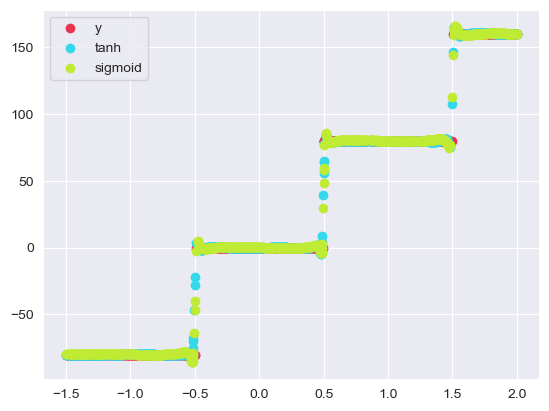

In [32]:
y1 = [N_sl_tanh.forward((sl_test['x'].values[i].reshape(1, 1) - N_sl_tanh.X_mean) / N_sl_tanh.X_std, True)[0][0] for i in range(len(sl_test['x'].values))]
y2 = [N_sl_sigm.forward((sl_test['x'].values[i].reshape(1, 1) - N_sl_tanh.X_mean) / N_sl_tanh.X_std, True)[0][0] for i in range(len(sl_test['x'].values))]
y_norm = (sl_test['y'] - np.mean(sl_train['y'])) / np.std(sl_train['y'])
plt.scatter(sl_test['x'], sl_test['y'], color='#eb344f', label='y')
plt.scatter(sl_test['x'], y1, color='#34d8eb', label='tanh')
plt.scatter(sl_test['x'], y2, color='#c0eb34', label='sigmoid')
plt.legend()

# Klasyfikacja

## Rings5-regular

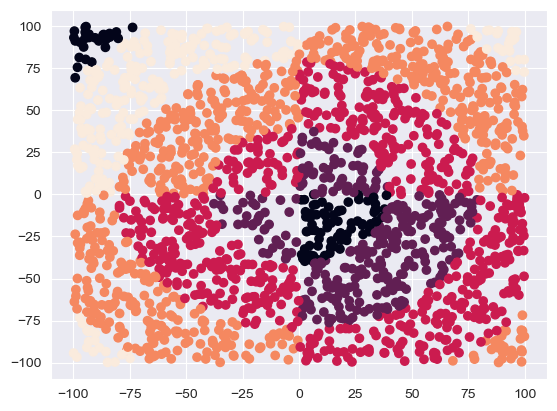

In [286]:
r5_train = pd.read_csv('NN\\classification\\rings5-regular-training.csv', dtype=np.longdouble)
r5_test = pd.read_csv('NN\\classification\\rings5-regular-test.csv', dtype=np.longdouble)
plt.scatter(r5_test['x'], r5_test['y'], c=r5_test['c'])

In [270]:
X_r5 = r5_train[['x', 'y']].to_numpy().transpose()
y_r5 = r5_train['c'].values.reshape(-1, 1)
X_test_r5 = r5_test[['x', 'y']].to_numpy().transpose()
y_test_r5 = r5_test['c'].values.reshape(-1, 1)
encoder = OneHotEncoder(sparse_output=False)
y_ohe_r5 = encoder.fit_transform(y_r5).transpose()
y_ohe_test_r5 = encoder.fit_transform(y_test_r5).transpose()

### Tanh()

In [275]:
layers = [10, 15, 10, 5]
fun_activation = [Tanh() for _ in range(len(layers) - 1)] + [Linear()]
params = {"eta": 0.006, "momentum": 0.9}

N_r5_tanh = Momentum_Network(size_layers=layers, size_input=2, activate_fun_array=fun_activation)
N_r5_tanh.train(X=X_r5, Y=y_ohe_r5, X_test=X_test_r5, Y_test=y_ohe_test_r5, epochs=6000, params=params, batch_size=64, type='classification', norm=True)

Epoch 1/6000, f-score = 0.26321446430357326, f-score test= 0.23935721875132815
Epoch 101/6000, f-score = 0.7343801520971739, f-score test= 0.6579599632778587
Epoch 201/6000, f-score = 0.8369269581636246, f-score test= 0.7673215727488628
Epoch 301/6000, f-score = 0.8680745356401287, f-score test= 0.790272122348527
Epoch 401/6000, f-score = 0.8638312407654158, f-score test= 0.7901553844003875
Epoch 501/6000, f-score = 0.8657072595532602, f-score test= 0.7973805477864673
Epoch 601/6000, f-score = 0.8746318699441303, f-score test= 0.8181310039179575
Epoch 701/6000, f-score = 0.8814117593599817, f-score test= 0.8331445599384496
Epoch 801/6000, f-score = 0.8834837827681079, f-score test= 0.8225928244442446
Epoch 901/6000, f-score = 0.8885150632108676, f-score test= 0.811016838423104
Epoch 1001/6000, f-score = 0.8897652262896838, f-score test= 0.8303320900835542
Epoch 1101/6000, f-score = 0.894391331605657, f-score test= 0.8240577372773682
Epoch 1201/6000, f-score = 0.8915051085351342, f-scor

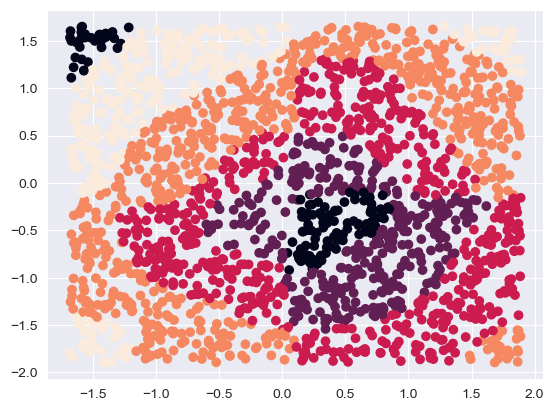

In [276]:
X_test_r5_norm = N_r5_tanh.z_score_normalize(X_test_r5, N_r5_tanh.X_mean, N_r5_tanh.X_std)
c = np.argmax(N_r5_tanh.Y_best_predict.transpose(), axis=1).tolist()
plt.scatter(X_test_r5_norm[0], X_test_r5_norm[1], c=c)

Epoch 1/6000, f-score = 0.6561422680533777, f-score test= 0.5620551715890959
Epoch 101/6000, f-score = 0.6262216954524958, f-score test= 0.5389156530639548
Epoch 201/6000, f-score = 0.5731728554527988, f-score test= 0.4891570087992324
Epoch 301/6000, f-score = 0.6211771792034404, f-score test= 0.5301876393227112
Epoch 401/6000, f-score = 0.6100998111012208, f-score test= 0.5132863653764173
Epoch 501/6000, f-score = 0.6459883448358215, f-score test= 0.5402428545082015
Epoch 601/6000, f-score = 0.6571886859004265, f-score test= 0.5467815081700056
Epoch 701/6000, f-score = 0.622850372221612, f-score test= 0.5466703390988756
Epoch 801/6000, f-score = 0.6492890654314826, f-score test= 0.5685165776744243
Epoch 901/6000, f-score = 0.6584980727988656, f-score test= 0.5908410218386283
Epoch 1001/6000, f-score = 0.6613057376919267, f-score test= 0.6104567390711956
Epoch 1101/6000, f-score = 0.6692668389016949, f-score test= 0.6201617475437435
Epoch 1201/6000, f-score = 0.6736475274283594, f-scor

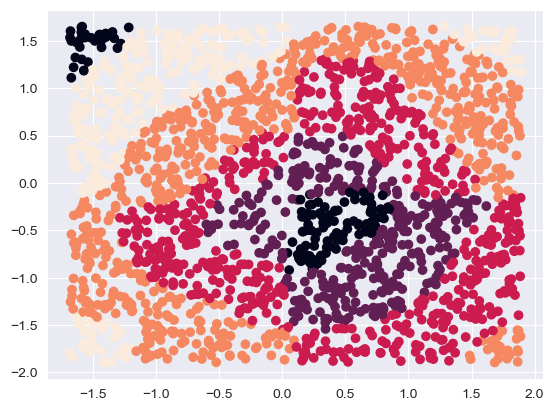

In [287]:
N_r5_tanh.train(X=X_r5, Y=y_ohe_r5, X_test=X_test_r5, Y_test=y_ohe_test_r5, epochs=6000, params=params, batch_size=64, type='classification', norm=True)
X_test_r5_norm = N_r5_tanh.z_score_normalize(X_test_r5, N_r5_tanh.X_mean, N_r5_tanh.X_std)
c = np.argmax(N_r5_tanh.Y_best_predict.transpose(), axis=1).tolist()
plt.scatter(X_test_r5_norm[0], X_test_r5_norm[1], c=c)

### Sigmoid()

In [280]:
layers = [10, 15, 10, 5]
fun_activation = [Sigmoid() for _ in range(len(layers) - 1)] + [Linear()]
params = {"eta": 0.01, "momentum": 0.8}

N_r5_sigm = Momentum_Network(size_layers=layers, size_input=2, activate_fun_array=fun_activation)
N_r5_sigm.train(X=X_r5, Y=y_ohe_r5, X_test=X_test_r5, Y_test=y_ohe_test_r5, epochs=6000, params=params, batch_size=64, type='classification', norm=True)

Epoch 1/6000, f-score = 0.06666666666666668, f-score test= 0.05352966652230402
Epoch 101/6000, f-score = 0.2535003637974123, f-score test= 0.22884110962399706
Epoch 201/6000, f-score = 0.2072136385027042, f-score test= 0.16392206477584598
Epoch 301/6000, f-score = 0.24824960136486068, f-score test= 0.22507923880202912
Epoch 401/6000, f-score = 0.24227129406421408, f-score test= 0.20327427432353512
Epoch 501/6000, f-score = 0.2498785918146064, f-score test= 0.22893885875324935
Epoch 601/6000, f-score = 0.25333612043349146, f-score test= 0.2214939949538465
Epoch 701/6000, f-score = 0.358543907773565, f-score test= 0.35029188815517814
Epoch 801/6000, f-score = 0.43916197323611883, f-score test= 0.42838234508447004
Epoch 901/6000, f-score = 0.5397171359992627, f-score test= 0.5085216209464213
Epoch 1001/6000, f-score = 0.6059290339294533, f-score test= 0.5622873314557297
Epoch 1101/6000, f-score = 0.6388213675334711, f-score test= 0.599057424881625
Epoch 1201/6000, f-score = 0.662898045678

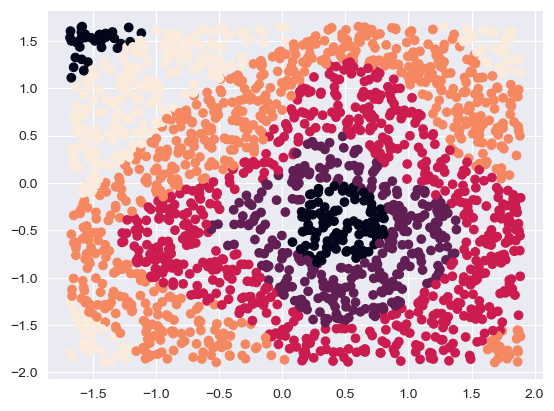

In [281]:
X_test_r5_norm2 = N_r5_sigm.z_score_normalize(X_test_r5, N_r5_sigm.X_mean, N_r5_sigm.X_std)
c = np.argmax(N_r5_sigm.Y_best_predict.transpose(), axis=1).tolist()
plt.scatter(X_test_r5_norm2[0], X_test_r5_norm2[1], c=c)

Epoch 1/6000, f-score = 0.8994648452308281, f-score test= 0.8498228118916582
Epoch 101/6000, f-score = 0.9019316942810868, f-score test= 0.8513339575669285
Epoch 201/6000, f-score = 0.89786347985176, f-score test= 0.8567406683938719
Epoch 301/6000, f-score = 0.8988160995460994, f-score test= 0.8595173692536685
Epoch 401/6000, f-score = 0.9034759152651295, f-score test= 0.8531575791452777
Epoch 501/6000, f-score = 0.9018221444983965, f-score test= 0.8547869952524548
Epoch 601/6000, f-score = 0.9018582628436818, f-score test= 0.8553423430457
Epoch 701/6000, f-score = 0.9085375966133477, f-score test= 0.8680321101453081
Epoch 801/6000, f-score = 0.9077205202556324, f-score test= 0.8655380622422392
Epoch 901/6000, f-score = 0.9085241667406159, f-score test= 0.869441695248869
Epoch 1001/6000, f-score = 0.9060436784061967, f-score test= 0.8643621974072511
Epoch 1101/6000, f-score = 0.90427747250384, f-score test= 0.8593069040698023
Epoch 1201/6000, f-score = 0.9093735233349982, f-score test=

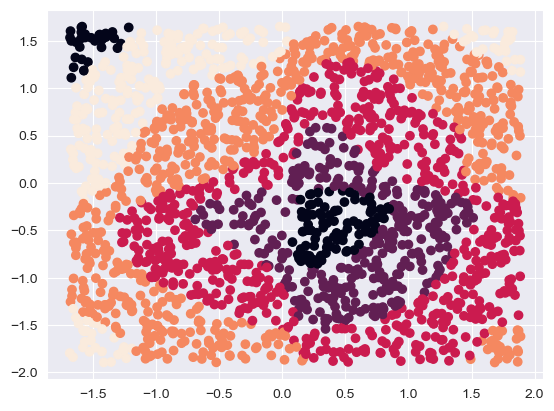

In [282]:
N_r5_sigm.train(X=X_r5, Y=y_ohe_r5, X_test=X_test_r5, Y_test=y_ohe_test_r5, epochs=6000, params=params, batch_size=64, type='classification', norm=True)
X_test_r5_norm2 = N_r5_sigm.z_score_normalize(X_test_r5, N_r5_sigm.X_mean, N_r5_sigm.X_std)
c = np.argmax(N_r5_sigm.Y_best_predict.transpose(), axis=1).tolist()
plt.scatter(X_test_r5_norm2[0], X_test_r5_norm2[1], c=c)

Epoch 1/6000, f-score = 0.9381258611795268, f-score test= 0.9021101809418927
Epoch 101/6000, f-score = 0.9446956373603201, f-score test= 0.9031342294480483
Epoch 201/6000, f-score = 0.9437977524486449, f-score test= 0.8965513515637136
Epoch 301/6000, f-score = 0.9446685348910577, f-score test= 0.90202767105463
Epoch 401/6000, f-score = 0.9455252907471072, f-score test= 0.90244024256637
Epoch 501/6000, f-score = 0.9430091945108119, f-score test= 0.9000824983011952
Epoch 601/6000, f-score = 0.9462840930986343, f-score test= 0.902016928391807
Epoch 701/6000, f-score = 0.9486639256447585, f-score test= 0.8962936830911854
Epoch 801/6000, f-score = 0.94704645251831, f-score test= 0.8993025029906395
Epoch 901/6000, f-score = 0.9462764776345493, f-score test= 0.9027250959798458
Epoch 1001/6000, f-score = 0.9470689280117461, f-score test= 0.9008581030465038
Epoch 1101/6000, f-score = 0.9471151938369067, f-score test= 0.9063448315110729
Epoch 1201/6000, f-score = 0.9462425761699735, f-score test

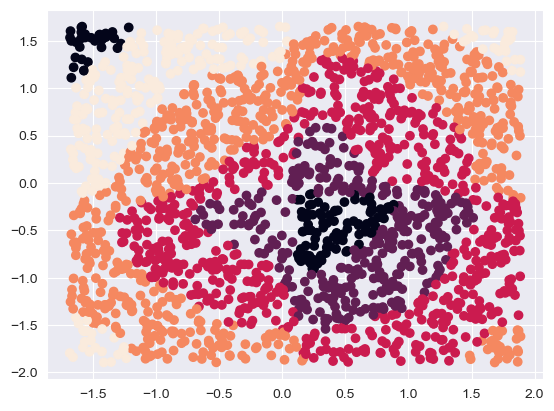

In [283]:
N_r5_sigm.train(X=X_r5, Y=y_ohe_r5, X_test=X_test_r5, Y_test=y_ohe_test_r5, epochs=6000, params=params, batch_size=64, type='classification', norm=True)
X_test_r5_norm2 = N_r5_sigm.z_score_normalize(X_test_r5, N_r5_sigm.X_mean, N_r5_sigm.X_std)
c = np.argmax(N_r5_sigm.Y_best_predict.transpose(), axis=1).tolist()
plt.scatter(X_test_r5_norm2[0], X_test_r5_norm2[1], c=c)

Epoch 1/6000, f-score = 0.9557848487845941, f-score test= 0.9138972614804194
Epoch 101/6000, f-score = 0.9590162419624253, f-score test= 0.91617374943106
Epoch 201/6000, f-score = 0.9574217852883798, f-score test= 0.9147958996203144
Epoch 301/6000, f-score = 0.9589907128810371, f-score test= 0.9190611996357234
Epoch 401/6000, f-score = 0.959031593431998, f-score test= 0.9150148134496833
Epoch 501/6000, f-score = 0.9573669805998168, f-score test= 0.9143115117921446
Epoch 601/6000, f-score = 0.959806677180301, f-score test= 0.9148563051262183
Epoch 701/6000, f-score = 0.956560476098748, f-score test= 0.9162567544057303
Epoch 801/6000, f-score = 0.9589265267219782, f-score test= 0.9171675952205718
Epoch 901/6000, f-score = 0.9589390862699384, f-score test= 0.9162607291251259
Epoch 1001/6000, f-score = 0.9597957174254995, f-score test= 0.9190451662270549
Epoch 1101/6000, f-score = 0.9605493612167292, f-score test= 0.9163264565092716
Epoch 1201/6000, f-score = 0.9614337551611103, f-score te

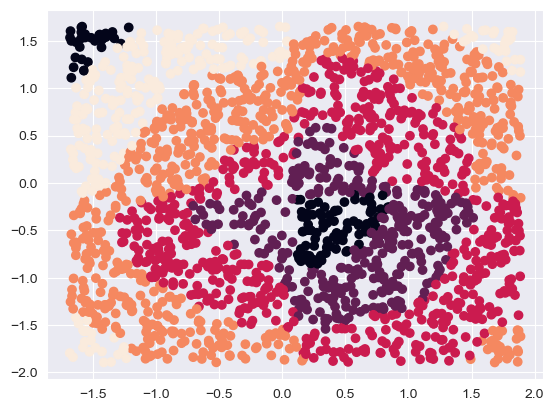

In [284]:
N_r5_sigm.train(X=X_r5, Y=y_ohe_r5, X_test=X_test_r5, Y_test=y_ohe_test_r5, epochs=6000, params=params, batch_size=64, type='classification', norm=True)
X_test_r5_norm2 = N_r5_sigm.z_score_normalize(X_test_r5, N_r5_sigm.X_mean, N_r5_sigm.X_std)
c = np.argmax(N_r5_sigm.Y_best_predict.transpose(), axis=1).tolist()
plt.scatter(X_test_r5_norm2[0], X_test_r5_norm2[1], c=c)

## Rings3-regular

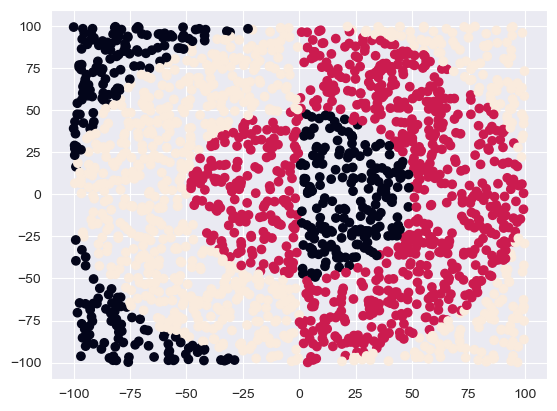

In [288]:
r3_train = pd.read_csv('NN\\classification\\rings3-regular-training.csv', dtype=np.longdouble)
r3_test = pd.read_csv('NN\\classification\\rings3-regular-test.csv', dtype=np.longdouble)
plt.scatter(r3_test['x'], r3_test['y'], c=r3_test['c'])

In [264]:
X_r3 = r3_train[['x', 'y']].to_numpy().transpose()
y_r3 = r3_train['c'].values.reshape(-1, 1)
X_test_r3 = r3_test[['x', 'y']].to_numpy().transpose()
y_test_r3 = r3_test['c'].values.reshape(-1, 1)
encoder = OneHotEncoder(sparse_output=False)
y_ohe_r3 = encoder.fit_transform(y_r3).transpose()
y_ohe_test_r3 = encoder.fit_transform(y_test_r3).transpose()

### Tanh()

In [292]:
layers = [10, 15, 10, 3]
fun_activation = [Tanh() for _ in range(len(layers) - 1)] + [Linear()]
params = {"eta": 0.001, "momentum": 0.9}

N_r3_tanh = Momentum_Network(size_layers=layers, size_input=2, activate_fun_array=fun_activation)
N_r3_tanh.train(X=X_r3, Y=y_ohe_r3, X_test=X_test_r3, Y_test=y_ohe_test_r3, epochs=4000, params=params, batch_size=64, type='classification', norm=True)

Epoch 1/4000, f-score = 0.416502696557814, f-score test= 0.44071548081282347
Epoch 101/4000, f-score = 0.8114021927574141, f-score test= 0.7862525192152501
Epoch 201/4000, f-score = 0.8523054165722215, f-score test= 0.8331007422724817
Epoch 301/4000, f-score = 0.8710973610116857, f-score test= 0.8514470130657811
Epoch 401/4000, f-score = 0.8911741337947804, f-score test= 0.8715383394617561
Epoch 501/4000, f-score = 0.9012252634001222, f-score test= 0.8861401154502523
Epoch 601/4000, f-score = 0.9134096581307559, f-score test= 0.9124756852682322
Epoch 701/4000, f-score = 0.9240087422427973, f-score test= 0.918987494532851
Epoch 801/4000, f-score = 0.9354341301602965, f-score test= 0.9267779675726081
Epoch 901/4000, f-score = 0.9407346035536966, f-score test= 0.9257081487444155
Epoch 1001/4000, f-score = 0.9426056252296279, f-score test= 0.9239580889270403
Epoch 1101/4000, f-score = 0.9452759930192287, f-score test= 0.9255759931765795
Epoch 1201/4000, f-score = 0.9433461027116895, f-scor

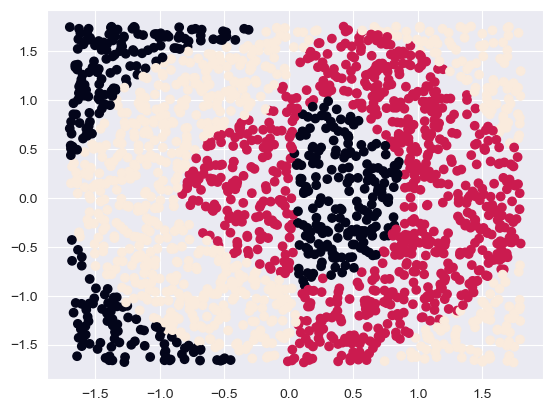

In [293]:
X_test_r3_norm = N_r3_tanh.z_score_normalize(X_test_r3, N_r3_tanh.X_mean, N_r3_tanh.X_std)
c = np.argmax(N_r3_tanh.Y_best_predict.transpose(), axis=1).tolist()
plt.scatter(X_test_r3_norm[0], X_test_r3_norm[1], c=c)

Epoch 1/4000, f-score = 0.9679010446098723, f-score test= 0.9466175432460903
Epoch 101/4000, f-score = 0.9692500356470696, f-score test= 0.9466355526235805
Epoch 201/4000, f-score = 0.9692572597908629, f-score test= 0.9474060156039473
Epoch 301/4000, f-score = 0.9665233439785567, f-score test= 0.9507963167802972
Epoch 401/4000, f-score = 0.9679507988291403, f-score test= 0.9481771540278917
Epoch 501/4000, f-score = 0.9666033230631736, f-score test= 0.9483412920834775
Epoch 601/4000, f-score = 0.9685927511342515, f-score test= 0.9501943744228329
Epoch 701/4000, f-score = 0.967944416703873, f-score test= 0.9483237216830606
Epoch 801/4000, f-score = 0.9679585296431252, f-score test= 0.9467161951519522
Epoch 901/4000, f-score = 0.9672597408648396, f-score test= 0.9455104616796831
Epoch 1001/4000, f-score = 0.9706081131136229, f-score test= 0.9480099852111376
Epoch 1101/4000, f-score = 0.9692966805562593, f-score test= 0.9468059366189013
Epoch 1201/4000, f-score = 0.9686381875912694, f-scor

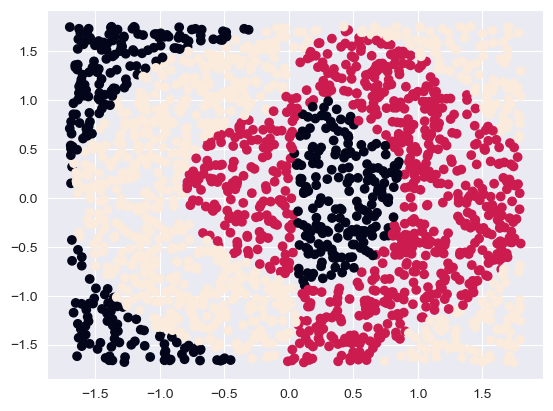

In [294]:
N_r3_tanh.train(X=X_r3, Y=y_ohe_r3, X_test=X_test_r3, Y_test=y_ohe_test_r3, epochs=4000, params=params, batch_size=64, type='classification', norm=True)
X_test_r3_norm = N_r3_tanh.z_score_normalize(X_test_r3, N_r3_tanh.X_mean, N_r3_tanh.X_std)
c = np.argmax(N_r3_tanh.Y_best_predict.transpose(), axis=1).tolist()
plt.scatter(X_test_r3_norm[0], X_test_r3_norm[1], c=c)

Epoch 1/4000, f-score = 0.9579521588821879, f-score test= 0.9260437299904103
Epoch 101/4000, f-score = 0.9579625975139637, f-score test= 0.9249736625642079
Epoch 201/4000, f-score = 0.9586291140980784, f-score test= 0.9264712137643872
Epoch 301/4000, f-score = 0.9566514679018336, f-score test= 0.9260075821021835
Epoch 401/4000, f-score = 0.9573165757954049, f-score test= 0.9261276069182992
Epoch 501/4000, f-score = 0.9559661224786108, f-score test= 0.9290279457515803
Epoch 601/4000, f-score = 0.958589539059726, f-score test= 0.9317975251519884
Epoch 701/4000, f-score = 0.9592246709786135, f-score test= 0.9334304469105105
Epoch 801/4000, f-score = 0.957915669119202, f-score test= 0.9327159742282544
Epoch 901/4000, f-score = 0.9546187725327696, f-score test= 0.9323650280832646
Epoch 1001/4000, f-score = 0.9579292161086913, f-score test= 0.9343312225461196
Epoch 1101/4000, f-score = 0.9532620665803019, f-score test= 0.9335739814752149
Epoch 1201/4000, f-score = 0.9505980760608898, f-score

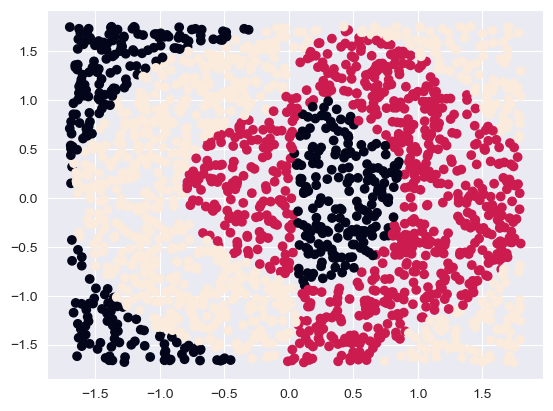

In [295]:
N_r3_tanh.train(X=X_r3, Y=y_ohe_r3, X_test=X_test_r3, Y_test=y_ohe_test_r3, epochs=4000, params=params, batch_size=64, type='classification', norm=True)
X_test_r3_norm = N_r3_tanh.z_score_normalize(X_test_r3, N_r3_tanh.X_mean, N_r3_tanh.X_std)
c = np.argmax(N_r3_tanh.Y_best_predict.transpose(), axis=1).tolist()
plt.scatter(X_test_r3_norm[0], X_test_r3_norm[1], c=c)

### Sigmoid()

In [291]:
layers = [10, 15, 10, 3]
fun_activation = [Sigmoid() for _ in range(len(layers) - 1)] + [Linear()]
params = {"eta": 0.01, "momentum": 0.8}

N_r3_sigm = Momentum_Network(size_layers=layers, size_input=2, activate_fun_array=fun_activation)
N_r3_sigm.train(X=X_r3, Y=y_ohe_r3, X_test=X_test_r3, Y_test=y_ohe_test_r3, epochs=4000, params=params, batch_size=64, type='classification', norm=True)

Epoch 1/4000, f-score = 0.26020167084001655, f-score test= 0.2860480600738905
Epoch 101/4000, f-score = 0.4648143819129986, f-score test= 0.46021965206922144
Epoch 201/4000, f-score = 0.4500734057529316, f-score test= 0.4508057426936891
Epoch 301/4000, f-score = 0.43631820625999973, f-score test= 0.42455595701572424
Epoch 401/4000, f-score = 0.40251309885843645, f-score test= 0.38458816543962265
Epoch 501/4000, f-score = 0.40857026775828803, f-score test= 0.390077473730224
Epoch 601/4000, f-score = 0.43375232770025707, f-score test= 0.4464612914216755
Epoch 701/4000, f-score = 0.45898121300697065, f-score test= 0.44691642188286673
Epoch 801/4000, f-score = 0.44836762442092465, f-score test= 0.4646985196361932
Epoch 901/4000, f-score = 0.47304990932048474, f-score test= 0.4649549499828863
Epoch 1001/4000, f-score = 0.5018555524584669, f-score test= 0.4990336820563938
Epoch 1101/4000, f-score = 0.6027397460084875, f-score test= 0.6231745047481686
Epoch 1201/4000, f-score = 0.762879660955

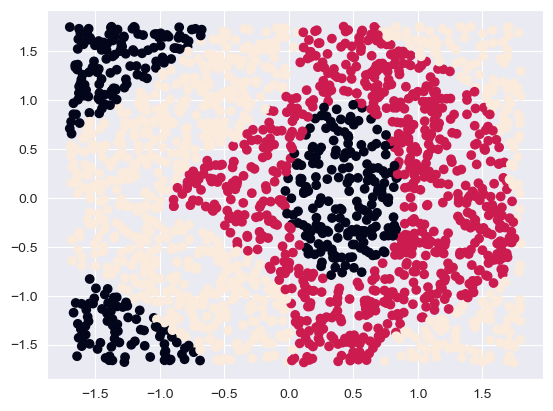

In [296]:
X_test_r3_norm2 = N_r3_sigm.z_score_normalize(X_test_r3, N_r3_sigm.X_mean, N_r3_sigm.X_std)
c = np.argmax(N_r3_sigm.Y_best_predict.transpose(), axis=1).tolist()
plt.scatter(X_test_r3_norm2[0], X_test_r3_norm2[1], c=c)

Epoch 1/4000, f-score = 0.9133689513571177, f-score test= 0.9038047019353851
Epoch 101/4000, f-score = 0.9113379666370071, f-score test= 0.9046450545040172
Epoch 201/4000, f-score = 0.9113387536739355, f-score test= 0.9052662397076264
Epoch 301/4000, f-score = 0.912004745859568, f-score test= 0.9063243161056486
Epoch 401/4000, f-score = 0.9126727810485242, f-score test= 0.9050336313317687
Epoch 501/4000, f-score = 0.9140097900754324, f-score test= 0.9053057081723644
Epoch 601/4000, f-score = 0.9120022180688766, f-score test= 0.9064303615479311
Epoch 701/4000, f-score = 0.9146717135704043, f-score test= 0.9068989190596463
Epoch 801/4000, f-score = 0.9146745713010773, f-score test= 0.9058930007306505
Epoch 901/4000, f-score = 0.9146659182995956, f-score test= 0.9072764488969268
Epoch 1001/4000, f-score = 0.9153414940132621, f-score test= 0.9067423231321387
Epoch 1101/4000, f-score = 0.9146769785945651, f-score test= 0.9058978536812242
Epoch 1201/4000, f-score = 0.916005291005291, f-score

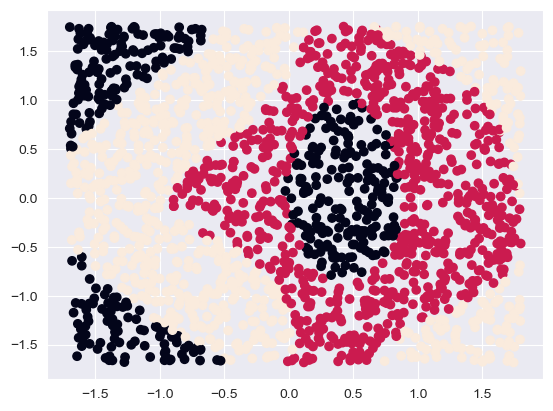

In [297]:
N_r3_sigm.train(X=X_r3, Y=y_ohe_r3, X_test=X_test_r3, Y_test=y_ohe_test_r3, epochs=4000, params=params, batch_size=64, type='classification', norm=True)
X_test_r3_norm2 = N_r3_sigm.z_score_normalize(X_test_r3, N_r3_sigm.X_mean, N_r3_sigm.X_std)
c = np.argmax(N_r3_sigm.Y_best_predict.transpose(), axis=1).tolist()
plt.scatter(X_test_r3_norm2[0], X_test_r3_norm2[1], c=c)